# Imports

In [67]:
import os
from platypus import NSGAII, Problem, Real, nondominated_sort, SBX, PM, GAOperator, Evaluator, run_job, Archive, Solution
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path
from shapely.geometry import Polygon, shape, Point
from descartes import PolygonPatch
import pylab as pl
from shapely import affinity
import random
import copy
from joblib import Parallel, delayed
import multiprocessing
import matplotlib

In [25]:
max_cores = multiprocessing.cpu_count()
print(max_cores)

12


In [26]:
os.chdir('C:/Users/zacha/Documents/GitHub/plymouth-university-proj518/data')
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\data


# OWF Problem

In [27]:
class OWF(Problem):
    def __init__(self, lon_limits, lat_limits, day_limits, data, map_polygon, wrecks_and_obstructions, shipping_density):
        """Locate optimal location (lat and long) in an area, to maximise
        Nvars: 11 (rotation of shape, lat/long center coordinates, 4 sets of lat/long offsets from center to define corners)
        """
        super(OWF, self).__init__(11, 5, 2)

        self.lat_limits = lat_limits
        self.lon_limits = lon_limits
        self.day_limits = day_limits

        self.data = data
        self.map_polygon = map_polygon
        self.wrecks_and_obstructions = wrecks_and_obstructions
        self.shipping_density = shipping_density

        #lat_range = lat_limits[1] - lat_limits[0]
        #lon_range = lon_limits[1] - lon_limits[0]

        # experimentally defined site size limitations
        lat_range = lon_range = 0.007201325686340829
        #lon_range = 5.203365643890723e-07

        # only predict locations within the site boundaries
        # allow predictions to be Real numbers (i.e. floats)
        self.types = [
            # polygon is rotated by rotation angle
            Real(0, 360),

            # center of site
            Real(self.lon_limits[0], self.lon_limits[1]),  # center lat
            Real(self.lat_limits[0], self.lat_limits[1]),  # center lon

            # corners are offset from center coordinates

            Real(-lon_range, 0),    # q1 lon
            Real(0, lat_range),     # q1 lat
            
            Real(0, lon_range),     # q2 lon
            Real(0, lat_range),     # q2 lat

            Real(0, lon_range),     # q3 lon
            Real(-lat_range, 0),    # q3 lat

            Real(-lon_range, 0),    # q4 lon
            Real(-lat_range, 0),    # q4 lat
        ]

        self.directions = [
            Problem.MAXIMIZE,   # maximise Velocity Potential
            Problem.MINIMIZE,   # minimise area used
            Problem.MINIMIZE,   # minimise differential of mean velocity potential across days
            Problem.MINIMIZE,   # minimise shipping density at solution
            Problem.MINIMIZE,   # minimise wrecks and obstructions within solution
        ]

        self.constraints[:] = [
           "==100",  # constrain valid shapes to have >98% intersection with site boundary
           #"<0.8",    # constrain area of sites to be less than 0.8 (experimentally defined)
           ">-40",   # contrain depth of site to max. 40m (invert bc depth goes -inf -> 0)
           #">80",      # constrain proximity to avoid other solutions
        ]

        self.parameter_testing = {} # for storing parameters altered during testing and identifying solution ranks

    def evaluate(self, solution):
        """Evaluate variables of solution to determine fitness.

        Solution variables contain the following:
            rotation: rotation of the polygon about the center point.

            center_lat: latitude of the center point.
            center_lon: longitude of the center point.

            q1_lat: latitude of the first point of the quadrilateral.
            q1_lon: longitude of the first point of the quadrilateral.
            q2_lat: latitude of the second point of the quadrilateral.
            q2_lon: longitude of the second point of the quadrilateral.
            q3_lat: latitude of the third point of the quadrilateral.
            q3_lon: longitude of the third point of the quadrilateral.
            q4_lat: latitude of the fourth point of the quadrilateral.
            q4_lon: longitude of the fourth point of the quadrilateral.
        """

        x = solution.variables[:]

        # read solution into variables
        rotation = x[0]
        center = x[1:3]
        q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]
        
        # calculate corner coordinates from center and q offset
        q1_coord = [center[0] + q1[0], center[1] + q1[1]]
        q2_coord = [center[0] + q2[0], center[1] + q2[1]]
        q3_coord = [center[0] + q3[0], center[1] + q3[1]]
        q4_coord = [center[0] + q4[0], center[1] + q4[1]]

        # rotation corner coordinates by rotation angle
        points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
        polygon = path.Path(points)

        # get bathymetryic and velocity potential data within polygon
        data_polygon = self.data[
            polygon.contains_points(self.data[["Lon", "Lat"]].values)
        ]

        # dataframe is empty, because no data at that location (out of bounds / too small)
        if data_polygon.empty:
            # make fitness infinitely bad
            area = np.inf
            depth = -np.inf
            velocity_potential = -np.inf
            velocity_potential_stability = np.inf
            shipping_density = np.inf
            wrecks_and_obstructions = np.inf
            intersection = -np.inf

        else:
            # get all wrecks and obstructions within polygon
            wrecks_and_obstructions = self.wrecks_and_obstructions[
                polygon.contains_points(self.wrecks_and_obstructions[["longitude", "latitude"]].values)
            ]
            # fitness is number of wrecks or obstructions inside polygon (less is better)
            wrecks_and_obstructions = len(wrecks_and_obstructions)

            # get shipping density by locating density polygon which contains center point
            shipping_density = np.inf
            for i, row in self.shipping_density.iterrows():
                # test if center is within row['polygon']
                if row['polygon'].contains_point(center):
                    shipping_density = row['yearly_avg']
                    break

            # calculate mean Velocity Potential
            velocity_potential = data_polygon.drop(['Lon', 'Lat', 'Depth'], axis=1)
            velocity_potential_mean = velocity_potential.mean(axis=1)

            # calculate stability of polygon
            # calculate difference between mean velocity potential at each day
            velocity_potential_stability = abs(velocity_potential_mean.diff().mean())

            # get mean Velocity Potential across all days
            velocity_potential = velocity_potential_mean.mean()    # repeat .mean() to get single mean of 2D array
            
            # calculate intersection of polygon with map polygon
            shapely_polygon = Polygon(points).buffer(0)

            # rotate polygon by rotation angle about center coordinate
            shapely_polygon = affinity.rotate(shapely_polygon, rotation, origin=center)

            # calculate intersection area between map polygon and solution polygon
            intersection = self.map_polygon.intersection(shapely_polygon).area
            intersection = intersection / shapely_polygon.area * 100.0

            # scale area of polygon
            area = shapely_polygon.area * 100.0

            # get max depth from bathymetric data polygon
            # with contraints, ensure turbines can be placed in any section of area
            # NOTE: if problems finding solutions - revert to mean depth, ensuring dominant % of polygon is viable regarding depth
            depth = data_polygon["Depth"].max()

        solution.objectives[:] = [
            velocity_potential,
            area,
            velocity_potential_stability,
            shipping_density,
            wrecks_and_obstructions,
        ]
        
        solution.constraints[:] = [
            intersection,
            depth,
        ]


## Custom Variator

* The default SBX Variator applies crossover to all decision variables in the solution.
* As the decision variables of our solution are spatial, meaning solutions for one location may not apply well to another, crossover at a high rate only results in solution covergence in the search space.
* To reduce this, we experiment with reducing probability of crossover between solutions for all or specific decision variables.

In [28]:
class CustomSBX(SBX):
    def __init__(self, apply_crossover=1.0, crossover_centre=1.0, crossover_others=1.0):
        super(CustomSBX, self).__init__()
        self.apply_crossover = apply_crossover
        self.crossover_centre = crossover_centre
        self.crossover_others = crossover_others

    def evolve(self, parents):
        child1 = copy.deepcopy(parents[0])
        child2 = copy.deepcopy(parents[1])
        
        if random.uniform(0.0, 1.0) <= self.apply_crossover:
            problem = child1.problem
            nvars = problem.nvars
            
            for i in range(nvars):
                if isinstance(problem.types[i], Real):
                    if ((i == 1 or i == 2) and random.uniform(0.0, 1.0) <= self.crossover_centre) or ((i != 1 and i != 2) and random.uniform(0.0, 1.0) <= self.crossover_others):
                        x1 = float(child1.variables[i])
                        x2 = float(child2.variables[i])
                        lb = problem.types[i].min_value
                        ub = problem.types[i].max_value
                        
                        x1, x2 = self.sbx_crossover(x1, x2, lb, ub)
                        
                        child1.variables[i] = x1
                        child2.variables[i] = x2
                        child1.evaluated = False
                        child2.evaluated = False
                    
        return [child1, child2]

## Multiprocessing evaluator

* Solutions can be evaluated independently, enabling parallelization on multi-core processors.
* By splitting computationally intensive task amongst cores, speed-up can be achieved.
* We augmented the MapEvaluator function (default evaluator applied to solutions) with multiprocessing to achieve this.

In [29]:
class MultiprocessingMapEvaluator(Evaluator):
    
    def __init__(self, num_cores, map_func=map):
        super(MultiprocessingMapEvaluator, self).__init__()
        self.map_func = map_func
        self.num_cores = num_cores

    def _chunks(self, items, n):
        result = []
        iterator = iter(items)
        
        try:
            while True:
                result.append(next(iterator))
                
                if len(result) == n:
                    yield result
                    result = []
        except StopIteration:
            if len(result) > 0:
                yield result
    
    def evaluate_job(self, chunk):
        return self.map_func(run_job, chunk)
    
    def evaluate_all(self, jobs, **kwargs):
        log_frequency = kwargs.get("log_frequency", None)
        
        if log_frequency is None:
            results = Parallel(n_jobs=self.num_cores)(delayed(run_job)(job) for job in jobs)

        else:
            results = Parallel(n_jobs=self.num_cores)(delayed(self.evaluate_job)(chunk) for chunk in self._chunks(jobs, log_frequency))

        return results

# Data

## Uk east coast velocity potential and bathymetry data

In [30]:
data = pd.read_csv("UK east coast velocity potential bathymetry.csv")

# NOTE: experimentally defined, enclosing area of map with depth >40m
lat_range = (53.486257927, 54.1)
lon_range = (0.5, 2.5571098)
days_range = (0, 288)

print(f"Latitude range: {lat_range}, Longitude range: {lon_range}")

print(data.head())

Latitude range: (53.486257927, 54.1), Longitude range: (0.5, 2.5571098)
        Lon        Lat          0          1          2          3          4  \
0  0.908810  53.508833 -4888854.5 -2964274.8 -1966400.0 -1944809.2 -322963.75   
1  0.982291  53.615490 -4988734.5 -3007930.2 -2047237.6 -2029393.5 -354367.40   
2  0.827796  53.586244 -4784387.0 -2952906.5 -1962346.2 -1973532.0 -356079.72   
3  0.837720  53.702704 -4801098.0 -2978041.2 -2017788.0 -2047978.2 -395331.00   
4  1.000396  53.708305 -5014005.5 -3031230.2 -2096183.8 -2092127.0 -384673.72   

           5          6          7  ...        220        221        222  \
0  1918140.2  2201700.2  497169.94  ...  3623697.0  3458370.5  3322026.8   
1  1893077.1  2230719.8  457650.47  ...  3645998.0  3475556.8  3341163.8   
2  1899125.8  2204834.5  470712.70  ...  3644461.0  3473458.5  3349537.8   
3  1871085.8  2224391.5  432494.90  ...  3669871.5  3497450.5  3374911.8   
4  1869927.0  2249043.0  425658.60  ...  3665922.8  3491546.0

## UK east coast edge points alpha 17.5 data

In [31]:
# read map polygon coords and create polygon
polygon_df = pd.read_csv("UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

map_polygon = Polygon(polygon_np)


## UK east coast wrecks and obstructions

In [32]:
wrecks_and_obstructions = pd.read_csv("UK east coast wrecks and obstructions.csv")

## UK east coast shipping density (2015)

In [33]:
shipping_density = pd.read_csv("UK east coast shipping density 2015.csv")

shipping_density['polygon'] = shipping_density['polygon'].apply(lambda x: path.Path(eval(x)))

# Parameter optimisation
* Multiple runs, labelling dominated fronts with run #, then viewing which runs produce dominated results

In [ ]:
# load the problem
problem = OWF(
    lat_limits=lat_range,
    lon_limits=lon_range,
    day_limits=days_range,
    data=data,
    map_polygon=map_polygon,
    wrecks_and_obstructions=wrecks_and_obstructions,
    shipping_density=shipping_density,
)

### Centre crossover

In [87]:
crossover_range = (0.0, 1.0)
crossover_step = 0.1

archive = Archive()

for i in range(0, int(crossover_range[1] / crossover_step)+1):
    crossover_probability = i * crossover_step
    print(f"Centre crossover probability: {crossover_probability}")
    
    algorithm = NSGAII(problem, population_size=100, variator=GAOperator(CustomSBX(crossover_centre=crossover_probability), PM()))
    
    # decrease generations by 500 each 0.1% increase to crossover probability
    generations = 10000 - (500 * i)
    print(f"Generations: {generations}")
    algorithm.run(generations)
    
    feasible_solutions = [s for s in algorithm.result if s.feasible]
    nondominated_sort(feasible_solutions)   # rank feasible solutions

    print(f"Nondominated: {len(feasible_solutions)}")

    # iterate through nondominated solutions and append to results dataframe
    for i, solution in enumerate(feasible_solutions):
        setattr(solution, "parameter_testing", dict())

        # set solution parameter testing centre crossover value to current crossover probability
        solution.parameter_testing['centre crossover'] = crossover_probability
        solution.parameter_testing['centre crossover rank'] = i

        # add solution to archive
        archive.append(solution)

Centre crossover probability: 0.0
Generations: 10000
Nondominated: 100
Centre crossover probability: 0.1
Generations: 9500
Nondominated: 100
Centre crossover probability: 0.2
Generations: 9000
Nondominated: 100
Centre crossover probability: 0.30000000000000004
Generations: 8500
Nondominated: 100
Centre crossover probability: 0.4
Generations: 8000
Nondominated: 100
Centre crossover probability: 0.5
Generations: 7500
Nondominated: 100
Centre crossover probability: 0.6000000000000001
Generations: 7000
Nondominated: 100
Centre crossover probability: 0.7000000000000001
Generations: 6500
Nondominated: 100
Centre crossover probability: 0.8
Generations: 6000
Nondominated: 100
Centre crossover probability: 0.9
Generations: 5500
Nondominated: 100
Centre crossover probability: 1.0
Generations: 5000
Nondominated: 100


In [88]:
results = pd.DataFrame(
    columns=[
        "Marker",
        "Rank",
        "rotation",
        "center_lon",
        "center_lat",
        "q1_lon",
        "q1_lat",
        "q2_lon",
        "q2_lat",
        "q3_lon",
        "q3_lat",
        "q4_lon",
        "q4_lat",
        "Velocity Potential",
        "Area",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "Centre crossover Probability",
    ]
)

markers = ["o", "v", "^", ">", "<", "s", "p", "P", "*", "h", "H", "D", "d", "X", "x", "1", "2", "3", "4", "8"]

# read nondominated solutions into dataframe
for i, solution in enumerate(archive):
    results.loc[i] = [markers[int(solution.parameter_testing['centre crossover'] / 0.1)], solution.rank, *solution.variables[:], *solution.objectives, solution.parameter_testing['centre crossover']]

results.replace([np.inf, -np.inf], np.nan, inplace=True)

results.dropna(inplace=True)

print(results['Centre crossover Probability'].value_counts())

0.2    43
0.9    42
0.7    29
0.3    22
0.5    19
0.0     9
0.1     8
1.0     7
0.4     6
0.6     5
0.8     2
Name: Centre crossover Probability, dtype: int64


In [89]:
def multidimensional6(r):
    # Visualizing 6-D mix data using bubble charts
    # leveraging the concepts of hue, size, depth and shape

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    t = fig.suptitle('Velocity potential - Stability - Area - Shipping density - Wrecks and obstructions')

    # calculate min and max values for Area
    rmin, rmax = r['Area'].min(), r['Area'].max()
    # calculate step size for Area
    rdiff = rmax - rmin
    sizing = ((r['Area'] - rmin) / rdiff) * 100  # calculate size as a percentage of max size, then scale to become a useful size in the plot
    
    for idx, row in r.iterrows():
        ax.scatter(row['Stability'], row['Shipping Density'], row['Wrecks and Obstructions'], alpha=0.4, c=row['Velocity Potential'], cmap='viridis', edgecolors='none', s=sizing[idx], marker=row['Marker'])

    ax.set_xlabel('Stability (mean deviation of Velocity Potential/year)')
    ax.set_ylabel('Shipping Density (mean shipping activity/week)')
    ax.set_zlabel('Wrecks and Obstructions (total wrecks / obstructions in solution space)')

    fig.text(.5, .05, 'Area (size of point is relative area of solution)', ha='center')

    # add a legend indicating the depth of each point
    cmap = matplotlib.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=r['Velocity Potential'].min(), vmax=r['Velocity Potential'].max())
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label('Velocity Potential (mean potential/year)')

    plt.show()

(192, 19)


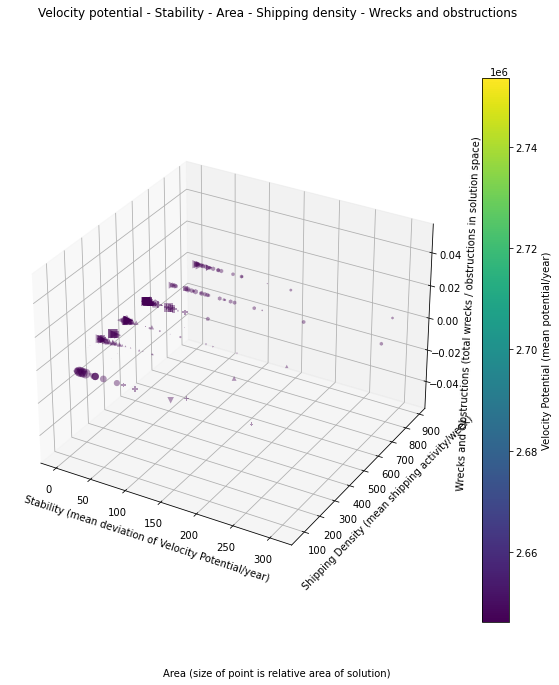

In [91]:
print(results.shape)

multidimensional6(results)